In [ ]:
'''
 * Copyright (c) 2005 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

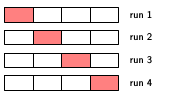

Figure.18 The technique of S-fold cross-validation, illus- trated here for the case of S = 4, involves tak- ing the available data and partitioning it into S groups (in the simplest case these are of equal size). Then S − 1 of the groups are used to train a set of models that are then evaluated on the re- maining group. This procedure is then repeated for all S possible choices for the held-out group, indicated here by the red blocks, and the perfor- mance scores from the S runs are then averaged.

# Model Selection

In our example of polynomial curve fitting using least squares, we saw that there was an optimal order of polynomial that gave the best generalization. The order of the polynomial controls the number of free parameters in the model and thereby governs the model complexity. With regularized least squares, the regularization coefficient $\lambda$ also controls the effective complexity of the model, whereas for more complex models, such as mixture distributions or neural networks, there may be multiple parameters governing complexity.

In a practical application, we need to determine the values of such parameters, and the principal objective in doing so is usually to achieve the best predictive performance on new data. Furthermore, as well as finding the appropriate values for complexity parameters within a given model, we may wish to consider a range of different types of model in order to find the best one for our particular application.

We have already seen that, in the maximum likelihood approach, the performance on the training set is not a good indicator of predictive performance on unseen data due to the problem of overfitting. If data is plentiful, then one approach is simply to use some of the available data to train a range of models, or a given model with a range of values for its complexity parameters, and then to compare them on independent data, sometimes called a validation set, and select the one having the best predictive performance.

If the model design is iterated many times using a limited size data set, then some overfitting to the validation data can occur and so it may be necessary to keep aside a third test set on which the performance of the selected model is finally evaluated. In many applications, however, the supply of data for training and testing will be limited, and in order to build good models, we wish to use as much of the available data as possible for training.

However, if the validation set is small, it will give a relatively noisy estimate of predictive performance. One solution to this dilemma is to use cross-validation, which is illustrated in Figure 1.18. This allows a proportion $\frac{S - 1}{S}$ of the available data to be used for training while making use of all of the data to assess performance.

## Cross-Validation Technique

The technique of $S$-fold cross-validation, illustrated here for the case of $S = 4$, involves taking the available data and partitioning it into $S$ groups (in the simplest case these are of equal size). Then $S - 1$ of the groups are used to train a set of models that are then evaluated on the remaining group. This procedure is then repeated for all $S$ possible choices for the held-out group, indicated here by the red blocks, and the performance scores from the $S$ runs are then averaged.

When data is particularly scarce, it may be appropriate to consider the case $S = N$, where $N$ is the total number of data points, which gives the leave-one-out technique. One major drawback of cross-validation is that the number of training runs that must be performed is increased by a factor of $S$, and this can prove problematic for models in which the training is itself computationally expensive.

A further problem with techniques such as cross-validation that use separate data to assess performance is that we might have multiple complexity parameters for a single model (for instance, there might be several regularization parameters). Exploring combinations of settings for such parameters could, in the worst case, require a number of training runs that is exponential in the number of parameters. Clearly, we need a better approach.

Ideally, this should rely only on the training data and should allow multiple hyperparameters and model types to be compared in a single training run. We therefore need to find a measure of performance which depends only on the training data and which does not suffer from bias due to overfitting. 

Historically, various ‘information criteria’ have been proposed that attempt to correct for the bias of maximum likelihood by the addition of a penalty term to compensate for the overfitting of more complex models. For example, the Akaike information criterion, or AIC (Akaike, 1974), chooses the model for which the quantity 

$$
\ln p(D|w_{ML}) - M
$$ 

is largest. Here $p(D|w_{ML})$ is the best-fit log likelihood, and $M$ is the number of adjustable parameters in the model. A variant of this quantity, called the Bayesian information criterion, or BIC, will be discussed in Section 4.4.1. 

Such criteria do not take account of the uncertainty in the model parameters, however, and in practice, they tend to favour overly simple models. We therefore turn in Section 3.4 to a fully Bayesian approach where we shall see how complexity penalties arise in a natural and principled way.


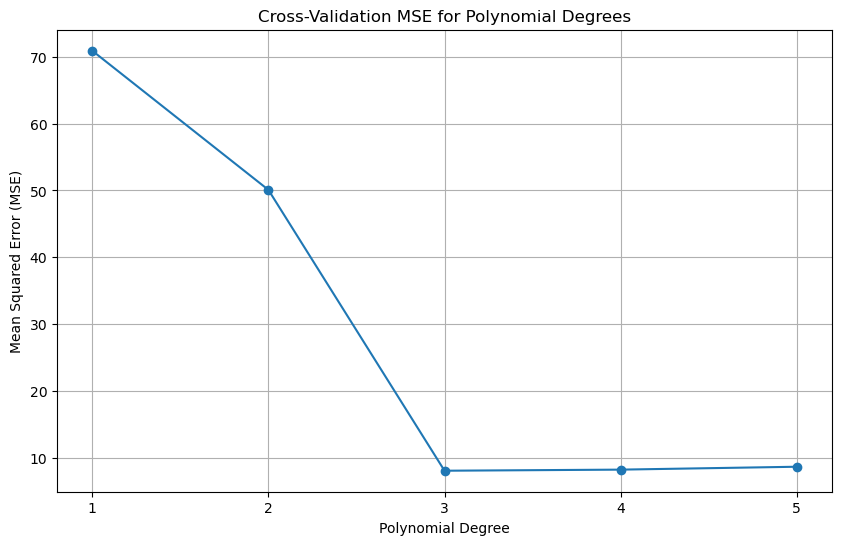

Best polynomial degree: 3


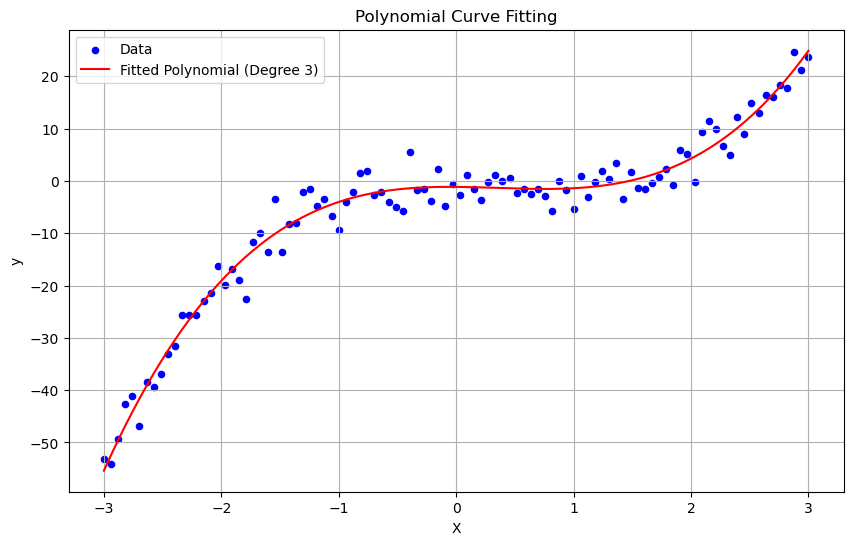

In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generating synthetic data
np.random.seed(0)  # For reproducibility
X = np.linspace(-3, 3, 100)
y = 1.5 * X**3 - 2 * X**2 + np.random.normal(scale=3, size=X.shape)  # Cubic relationship with noise

# Polynomial fitting function
def polynomial_fit(X, y, degree):
    """Fit a polynomial of a given degree to the data."""
    # Creating the Vandermonde matrix for polynomial regression
    A = np.vander(X, degree + 1)  # Vandermonde matrix
    # Calculating the coefficients using least squares
    coeffs = np.linalg.lstsq(A, y, rcond=None)[0]
    return coeffs

# Predicting function
def predict(X, coeffs):
    """Predict values using the polynomial coefficients."""
    return np.vander(X, len(coeffs)) @ coeffs

# Cross-validation function
def cross_validation(X, y, degree, folds=5):
    """Perform K-fold cross-validation on the polynomial model."""
    fold_size = len(X) // folds
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    mse_scores = []

    for fold in range(folds):
        # Splitting indices for training and validation
        val_indices = indices[fold * fold_size:(fold + 1) * fold_size]
        train_indices = np.concatenate((indices[:fold * fold_size], indices[(fold + 1) * fold_size:]))

        # Training data
        X_train, y_train = X[train_indices], y[train_indices]
        # Validation data
        X_val, y_val = X[val_indices], y[val_indices]

        # Fit polynomial model
        coeffs = polynomial_fit(X_train, y_train, degree)
        # Predict on validation set
        y_pred = predict(X_val, coeffs)

        # Calculate Mean Squared Error
        mse = np.mean((y_val - y_pred) ** 2)
        mse_scores.append(mse)

    return np.mean(mse_scores)

# Fitting polynomials of different degrees and evaluating using cross-validation
degrees = [1, 2, 3, 4, 5]
cv_scores = [cross_validation(X, y, d) for d in degrees]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(degrees, cv_scores, marker='o', linestyle='-')
plt.title('Cross-Validation MSE for Polynomial Degrees')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(degrees)
plt.grid(True)
plt.show()

# Final fitting with the best degree
best_degree = degrees[np.argmin(cv_scores)]
print(f'Best polynomial degree: {best_degree}')

# Fit the final model and plot
final_coeffs = polynomial_fit(X, y, best_degree)
X_fit = np.linspace(-3, 3, 300)
y_fit = predict(X_fit, final_coeffs)

# Plotting the fitted polynomial
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data', s=20)
plt.plot(X_fit, y_fit, color='red', label=f'Fitted Polynomial (Degree {best_degree})')
plt.title('Polynomial Curve Fitting')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


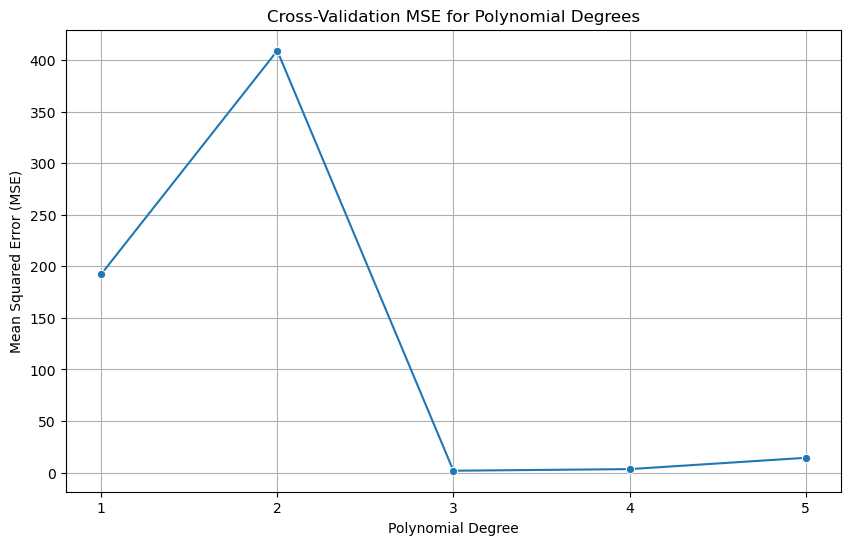

Best polynomial degree: 3


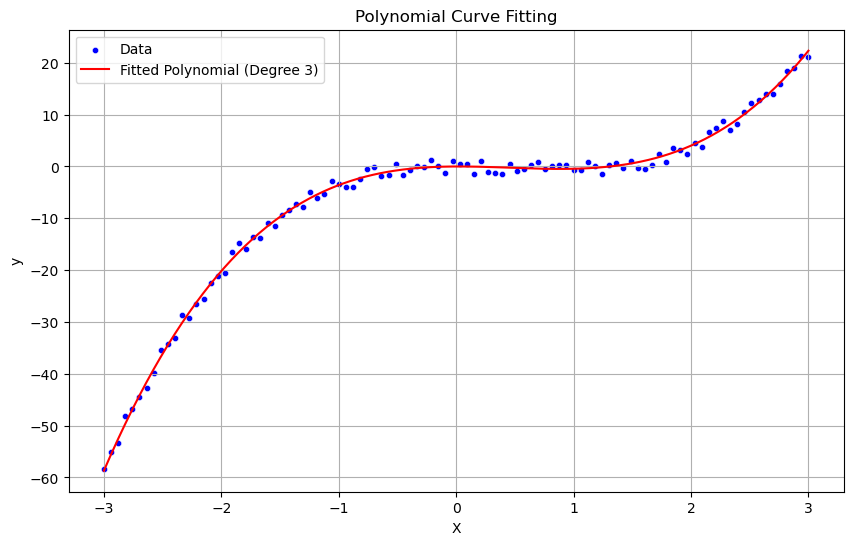

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Generate synthetic data
def generate_data(num_points=100, noise_level=3):
    """Generate synthetic cubic data with noise."""
    X = [-3 + 6 * i / (num_points - 1) for i in range(num_points)]  # X values from -3 to 3
    y = [1.5 * x**3 - 2 * x**2 + noise_level * (random.random() - 0.5) for x in X]  # Cubic relationship with noise
    return X, y

# Polynomial fitting function
def polynomial_fit(X, y, degree):
    """Fit a polynomial of a given degree to the data."""
    n = len(X)
    
    # Create the Vandermonde matrix
    A = [[x**d for d in range(degree + 1)] for x in X]

    # Calculate A^T * A
    ATA = [[0] * (degree + 1) for _ in range(degree + 1)]
    for i in range(degree + 1):
        for j in range(degree + 1):
            ATA[i][j] = sum(A[k][i] * A[k][j] for k in range(n))

    # Calculate A^T * y
    ATy = [sum(A[k][d] * y[k] for k in range(n)) for d in range(degree + 1)]

    # Solve for coefficients using Gaussian elimination
    coeffs = [0] * (degree + 1)
    for i in range(degree + 1):
        for j in range(i + 1, degree + 1):
            factor = ATA[j][i] / ATA[i][i]
            for k in range(i, degree + 1):
                ATA[j][k] -= factor * ATA[i][k]
            ATy[j] -= factor * ATy[i]

    for i in range(degree, -1, -1):
        coeffs[i] = ATy[i]
        for j in range(i + 1, degree + 1):
            coeffs[i] -= ATA[i][j] * coeffs[j]
        coeffs[i] /= ATA[i][i]

    return coeffs

# Predicting function
def predict(X, coeffs):
    """Predict values using the polynomial coefficients."""
    return [sum(coeffs[d] * (x ** d) for d in range(len(coeffs))) for x in X]

# Cross-validation function
def cross_validation(X, y, degree, folds=5):
    """Perform K-fold cross-validation on the polynomial model."""
    fold_size = len(X) // folds
    mse_scores = []

    for fold in range(folds):
        # Splitting the data into training and validation sets
        val_indices = list(range(fold * fold_size, (fold + 1) * fold_size))
        train_indices = [i for i in range(len(X)) if i not in val_indices]

        # Training data
        X_train = [X[i] for i in train_indices]
        y_train = [y[i] for i in train_indices]
        # Validation data
        X_val = [X[i] for i in val_indices]
        y_val = [y[i] for i in val_indices]

        # Fit polynomial model
        coeffs = polynomial_fit(X_train, y_train, degree)
        # Predict on validation set
        y_pred = predict(X_val, coeffs)

        # Calculate Mean Squared Error
        mse = sum((y_val[i] - y_pred[i]) ** 2 for i in range(len(y_val))) / len(y_val)
        mse_scores.append(mse)

    return sum(mse_scores) / len(mse_scores)

# Main execution
# Generate synthetic data
X, y = generate_data()

# Fitting polynomials of different degrees and evaluating using cross-validation
degrees = [1, 2, 3, 4, 5]
cv_scores = [cross_validation(X, y, d) for d in degrees]

# Plotting the results using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=degrees, y=cv_scores, marker='o', linestyle='-')
plt.title('Cross-Validation MSE for Polynomial Degrees')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(degrees)
plt.grid(True)
plt.show()

# Final fitting with the best degree
best_degree = degrees[cv_scores.index(min(cv_scores))]
print(f'Best polynomial degree: {best_degree}')

# Fit the final model and plot
final_coeffs = polynomial_fit(X, y, best_degree)
X_fit = [-3 + 6 * i / 299 for i in range(300)]  # Generate points for plotting the fit
y_fit = predict(X_fit, final_coeffs)

# Plotting the fitted polynomial
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X, y=y, color='blue', label='Data', s=20)
sns.lineplot(x=X_fit, y=y_fit, color='red', label=f'Fitted Polynomial (Degree {best_degree})')
plt.title('Polynomial Curve Fitting')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


## The Curse of Dimensionality

In the polynomial curve fitting example, we had just one input variable $x$. For practical applications of pattern recognition, however, we must deal with high-dimensional spaces comprising many input variables. This poses serious challenges and is an important factor influencing the design of pattern recognition techniques.

To illustrate the problem, we consider a synthetically generated data set representing measurements taken from a pipeline containing a mixture of oil, water, and gas (Bishop and James, 1993). These three materials can be present in one of three different geometrical configurations known as ‘homogeneous’, ‘annular’, and ‘laminar’, with varying fractions.

Each data point comprises a 12-dimensional input vector consisting of measurements taken with gamma ray densitometers that measure the attenuation of gamma rays passing along narrow beams through the pipe. 

### Data Visualization

Figure.19 shows 100 points from this dataset plotted using two of the measurements $x_6$ and $x_7$ (the remaining ten input values are ignored for illustration purposes). Each data point is labeled according to its respective geometrical class:

- **Red**: Homogeneous class
- **Green**: Annular class
- **Blue**: Laminar class

Our goal is to use this data as a training set to classify a new observation $(x_6, x_7)$, denoted by the cross in Figure.19. 

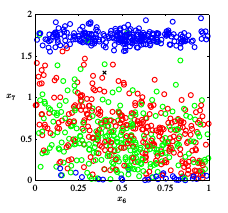

Figure.19 Scatter plot of the oil ﬂow data for input variables x6 and x7 , in which red denotes the ‘homoge- nous’ class, green denotes the ‘annular’ class, and blue denotes the ‘laminar’ class. Our goal is to classify the new test point de- noted by ‘×’.

### Observations

- The cross is surrounded by numerous red points, suggesting it might belong to the red class.
- There are also plenty of green points nearby, indicating it could belong to the green class.
- It seems unlikely that it belongs to the blue class.

The identity of the cross should be determined more strongly by nearby points from the training set and less strongly by more distant points. This intuition leads us to consider a learning algorithm.

### Simple Classification Approach

One simple approach would be to divide the input space into regular cells, as illustrated in Figure.20. When given a test point, we would:

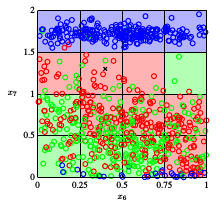

Figure.20 Illustration of a simple approach to the solution of a classiﬁcation problem in which the input space is divided into cells and any new test point is assigned to the class that has a majority number of rep- resentatives in the same cell as the test point. As we shall see shortly, this simplistic approach has some severe shortcomings.

1. Decide which cell it belongs to.
2. Find all training data points in the same cell.
3. Predict the class based on the majority class in that cell.

### Challenges of High Dimensionality

However, this naive approach has severe shortcomings, especially as we consider higher dimensionality. 

The origin of the problem is illustrated in Figure 1.21, which shows that dividing a region of space into regular cells causes the number of cells to grow exponentially with the dimensionality of the space. 

- If we have $d$ dimensions, the number of cells can be expressed as $N_{cells} = k^d$, where $k$ is the number of divisions along each dimension.
- Consequently, we need an exponentially larger quantity of training data to ensure that the cells are not empty.

Clearly, we cannot apply such a technique in spaces with more than a few variables, necessitating the development of more sophisticated approaches.

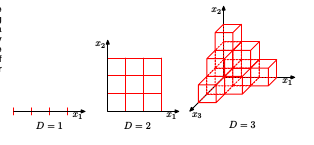

Figure.21 Illustration of the curse of dimensionality, showing how the number of regions of a regular grid grows exponentially with the dimensionality D of the space. For clarity, only a subset of the cubical regions are shown for D = 3.


## Extending Polynomial Fitting to High-Dimensional Spaces

To extend the approach of polynomial curve fitting to input spaces with several variables, consider $D$ input variables. A general polynomial with coefficients up to order 3 can be expressed as:

$$
y(x, w) = w_0 + \sum_{i=1}^{D} w_i x_i + \sum_{i=1}^{D} \sum_{j=1}^{D} w_{ij} x_i x_j + \sum_{i=1}^{D} \sum_{j=1}^{D} \sum_{k=1}^{D} w_{ijk} x_i x_j x_k
$$

As $D$ increases, the number of independent coefficients grows proportionally to $D^3$. In practice, to capture complex dependencies in the data, we may need to use a higher-order polynomial. For a polynomial of order $M$, the growth in the number of coefficients is approximately $D^M$. 

Although this growth is a power law rather than exponential, it still indicates that the method can become rapidly unwieldy and of limited practical utility.

## Geometric Intuitions in High Dimensions

Our geometrical intuitions, shaped by experience in three-dimensional spaces, can fail dramatically in higher-dimensional contexts. As an example, consider a sphere of radius $r = 1$ in a $D$-dimensional space and analyze the fraction of the sphere's volume that lies between radius $r = 1 - \epsilon$ and $r = 1$. 

### Volume of a Sphere

The volume $V_D(r)$ of a sphere of radius $r$ in $D$ dimensions can be expressed as:

$$
V_D(r) = K_D r^D
$$

where \(K_D\) is a constant dependent only on \(D\). The required fraction of the volume is then given by:

$$
\frac{V_D(1) - V_D(1 - \epsilon)}{V_D(1)} = 1 - (1 - \epsilon)^D
$$

This fraction is plotted as a function of $\epsilon$ for various values of $D$ in Figure .22. 

- For large $D$, this fraction tends to 1 even for small values of $\epsilon$. 
- Thus, in high-dimensional spaces, most of the volume of a sphere is concentrated in a thin shell near the surface.

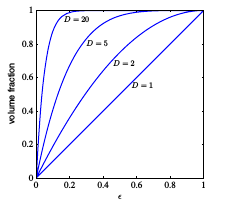


## Behavior of Gaussian Distributions in High Dimensions

Considering the behavior of a Gaussian distribution in a high-dimensional space, if we transform from Cartesian to polar coordinates and integrate out the directional variables, we can express the density $p(r)$ as a function of the radius $r$ from the origin. 

The probability mass $p(r) \delta r$ inside a thin shell of thickness $\delta r$ located at radius $r$ shows that for large $D$, the probability mass of the Gaussian is concentrated in a thin shell.

This phenomenon is often referred to as the **curse of dimensionality** (Bellman, 1961). 

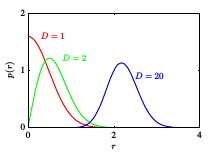

Figure.23 Plot of the probability density with respect to radius r of a Gaussian distribution for various values of the dimensionality D. In a high-dimensional space, most of the probability mass of a Gaussian is lo- cated within a thin shell at a speciﬁc radius.

## Practical Implications for Pattern Recognition

Despite the challenges posed by the curse of dimensionality, effective techniques applicable to high-dimensional spaces can still be developed for two primary reasons:

1. **Confinement to Lower Dimensional Regions**: Real data often resides in a region of the space with lower effective dimensionality. The directions of significant variation in the target variables may be confined to these lower dimensions.
  
2. **Smoothness Properties of Real Data**: Real data typically exhibits some smoothness properties (at least locally), meaning that small changes in the input variables yield small changes in the target variables. This allows us to use local interpolation-like techniques for predictions.

### Example: Manufacturing Applications

In a manufacturing scenario where images of identical planar objects on a conveyor belt are captured, the goal might be to determine their orientation. Each image corresponds to a point in a high-dimensional space defined by the number of pixels. Since the objects can vary in position and orientation, there are three degrees of freedom of variability between images, leading to a three-dimensional manifold embedded within the high-dimensional space. 

Due to the complex relationships between the object's position or orientation and pixel intensities, this manifold will be highly nonlinear. If the objective is to develop a model that can take an input image and output the orientation of the object, only one degree of freedom of variability within the manifold is significant.



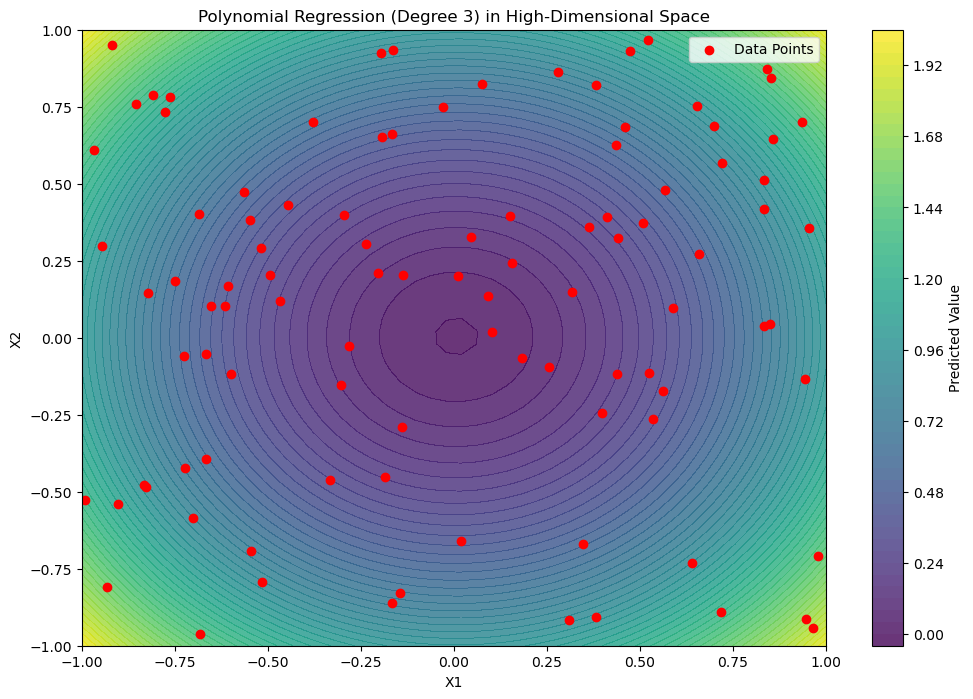

In [8]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Function to generate synthetic high-dimensional data
def generate_data(num_points, dim):
    X = []
    y = []
    for _ in range(num_points):
        # Generate random points in D dimensions
        point = [random.uniform(-1, 1) for _ in range(dim)]
        X.append(point)
        
        # Generate the target variable using a polynomial function
        # Here we consider a simple polynomial: y = x1^2 + x2^2 + ... + xD^2
        target = sum(x ** 2 for x in point) + random.uniform(-0.1, 0.1)  # Adding noise
        y.append(target)
    
    return np.array(X), np.array(y)

# Polynomial regression function
def polynomial_regression(X, y, degree):
    # Create polynomial features
    poly_features = np.ones((X.shape[0], 1))  # Start with a column of ones for the bias term
    for d in range(1, degree + 1):
        # Add each dimension raised to the power of d
        for i in range(X.shape[1]):
            poly_features = np.column_stack((poly_features, X[:, i] ** d))
    
    # Calculate coefficients using the normal equation
    coefficients = np.linalg.inv(poly_features.T @ poly_features) @ poly_features.T @ y
    return coefficients

# Prediction function
def predict(X, coefficients, degree):
    poly_features = np.ones((X.shape[0], 1))  # Start with a column of ones for the bias term
    for d in range(1, degree + 1):
        for i in range(X.shape[1]):
            poly_features = np.column_stack((poly_features, X[:, i] ** d))
    return poly_features @ coefficients

# Parameters
num_points = 100
dim = 3  # Dimensionality of input space
degree = 3  # Degree of polynomial

# Generate data
X, y = generate_data(num_points, dim)

# Perform polynomial regression
coefficients = polynomial_regression(X, y, degree)

# Making predictions for visualization (consider only the first two dimensions)
x1_range = np.linspace(-1, 1, 50)
x2_range = np.linspace(-1, 1, 50)
X1, X2 = np.meshgrid(x1_range, x2_range)
X_pred = np.array([X1.ravel(), X2.ravel()]).T

# Adding dummy dimensions (set to zero for unused dimensions)
X_pred_high_dim = np.hstack([X_pred, np.zeros((X_pred.shape[0], dim - 2))])

# Predicting target values
y_pred = predict(X_pred_high_dim, coefficients, degree)

# Reshape predictions for contour plotting
Y_pred = y_pred.reshape(X1.shape)

# Plotting the results
plt.figure(figsize=(12, 8))
plt.contourf(X1, X2, Y_pred, levels=50, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted Value')
plt.scatter(X[:, 0], X[:, 1], c='red', marker='o', label='Data Points')
plt.title(f'Polynomial Regression (Degree {degree}) in High-Dimensional Space')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()


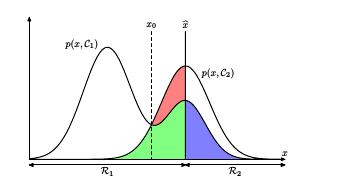  

Figure 24 Schematic illustration of the joint probabilities $p(x, C_k )$ for each of two classes plotted against x, together with the decision boundary $x = \hat{x}$. Values of x x b are classiﬁed as class $C_2$ and hence belong to decision region R2 , whereas points x < x b are classiﬁed as $C_1$ and belong to $R_1$ . Errors arise from the blue, green, and red regions, so that for $ x < \hat{x} $ the errors are due to points from class C2 being misclassiﬁed as $C_1$ (represented by the sum of the red and green regions), and conversely for points in the region $ x \geq \hat{x} $ the errors are due to points from class C1 being misclassiﬁed as $C_2$ (represented by the blue region). As we vary the location x b of the decision boundary, the combined areas of the blue and green regions remains constant, whereas the size of the red region varies. The optimal choice for $\hat{x}$ is where the curves for $p(x, C_1 )$ and $p(x, C_2 $ cross, corresponding to $b = x_0$ , because in this case the red region disappears. This is equivalent to the minimum x misclassiﬁcation rate decision rule, which assigns each value of x to the class having the higher posterior probability $p(C_k |x)$.

# Decision Theory

We have seen in Section 1.2 how probability theory provides us with a consistent mathematical framework for quantifying and manipulating uncertainty. Here we turn to a discussion of decision theory that, when combined with probability theory, allows us to make optimal decisions in situations involving uncertainty such as those encountered in pattern recognition.

Suppose we have an input vector $ \mathbf{x} $ together with a corresponding vector $ \mathbf{t} $ of target variables, and our goal is to predict $ \mathbf{t} $ given a new value for $ \mathbf{x} $. For regression problems, $ \mathbf{t} $ will comprise continuous variables, whereas for classification problems $ \mathbf{t} $ will represent class labels. The joint probability distribution $ p(\mathbf{x}, \mathbf{t}) $ provides a complete summary of the uncertainty associated with these variables.

Determination of $ p(\mathbf{x}, \mathbf{t}) $ from a set of training data is an example of inference and is typically a very difficult problem whose solution forms the subject of much of this book. In a practical application, however, we must often make a specific prediction for the value of $ \mathbf{t} $, or more generally take a specific action based on our understanding of the values $ \mathbf{t} $ is likely to take, and this aspect is the subject of decision theory.

Consider, for example, a medical diagnosis problem in which we have taken an X-ray image of a patient, and we wish to determine whether the patient has cancer or not. In this case, the input vector $ \mathbf{x} $ is the set of pixel intensities in the image, and the output variable $ \mathbf{t} $ will represent the presence of cancer, which we denote by the class $ C_1 $, or the absence of cancer, which we denote by the class $ C_2 $. We might, for instance, choose $ \mathbf{t} $ to be a binary variable such that $ \mathbf{t} = 0 $ corresponds to class $ C_1 $ and $ \mathbf{t} = 1 $ corresponds to class $ C_2 $. 

We shall see later that this choice of label values is particularly convenient for probabilistic models. The general inference problem then involves determining the joint distribution $ p(\mathbf{x}, C_k) $, or equivalently $ p(\mathbf{x}, \mathbf{t}) $, which gives us the most complete probabilistic description of the situation. Although this can be a very useful and informative quantity, in the end we must decide either to give treatment to the patient or not, and we would like this choice to be optimal in some appropriate sense (Duda and Hart, 1973). This is the decision step, and it is the subject of decision theory to tell us how to make optimal decisions given the appropriate probabilities.

We shall see that the decision stage is generally very simple, even trivial, once we have solved the inference problem. Here we give an introduction to the key ideas of decision theory as required for the rest of the book. Further background, as well as more detailed accounts, can be found in Berger (1985) and Bather (2000).

Before giving a more detailed analysis, let us first consider informally how we might expect probabilities to play a role in making decisions. When we obtain the X-ray image $ \mathbf{x} $ for a new patient, our goal is to decide which of the two classes to assign to the image. We are interested in the probabilities of the two classes given the image, which are given by:

$$
p(C_k | \mathbf{x}) = \frac{p(\mathbf{x} | C_k)p(C_k)}{p(\mathbf{x})} \quad (1.77)
$$

Note that any of the quantities appearing in Bayes’ theorem can be obtained from the joint distribution $ p(\mathbf{x}, C_k) $ by either marginalizing or conditioning with respect to the appropriate variables. We can now interpret $ p(C_k) $ as the prior probability for the class $ C_k $, and $ p(C_k | \mathbf{x}) $ as the corresponding posterior probability. Thus, $ p(C_1) $ represents the probability that a person has cancer, before we take the X-ray measurement. Similarly, $ p(C_1 | \mathbf{x}) $ is the corresponding probability, revised using Bayes’ theorem in light of the information contained in the X-ray.

If our aim is to minimize the chance of assigning $ \mathbf{x} $ to the wrong class, then intuitively we would choose the class having the higher posterior probability. We now show that this intuition is correct, and we also discuss more general criteria for making decisions.

## 1.5.1 Minimizing the Misclassification Rate

Suppose that our goal is simply to make as few misclassifications as possible. We need a rule that assigns each value of $ \mathbf{x} $ to one of the available classes. Such a rule will divide the input space into regions $ R_k $ called decision regions, one for each class, such that all points in $ R_k $ are assigned to class $ C_k $. The boundaries between decision regions are called decision boundaries or decision surfaces. Note that each decision region need not be contiguous but could comprise some number of disjoint regions. We shall encounter examples of decision boundaries and decision regions in later chapters.

In order to find the optimal decision rule, consider first of all the case of two classes, as in the cancer problem for instance. A mistake occurs when an input vector belonging to class $ C_1 $ is assigned to class $ C_2 $ or vice versa. The probability of this occurring is given by:

$$
p(\text{mistake}) = p(\mathbf{x} \in R_1, C_2) + p(\mathbf{x} \in R_2, C_1) = \int_{R_1} p(\mathbf{x}, C_2) d\mathbf{x} + \int_{R_2} p(\mathbf{x}, C_1) d\mathbf{x} \quad (1.78)
$$

We are free to choose the decision rule that assigns each point $ \mathbf{x} $ to one of the two classes. Clearly, to minimize $ p(\text{mistake}) $, we should arrange that each $ \mathbf{x} $ is assigned to whichever class has the smaller value of the integrand in (1.78). Thus, if $ p(\mathbf{x}, C_1) > p(\mathbf{x}, C_2) $ for a given value of $\mathbf{x} $, then we should assign that $ \mathbf{x} $ to class $ C_1 $. 

From the product rule of probability, we have:

$$
p(\mathbf{x}, C_k) = p(C_k | \mathbf{x}) p(\mathbf{x}).
$$

Because the factor $ p(\mathbf{x}) $ is common to both terms, we can restate this result as saying that the minimum probability of making a mistake is obtained if each value of $ \mathbf{x} $ is assigned to the class for which the posterior probability $ p(C_k | \mathbf{x}) $ is largest. 

This result is illustrated for two classes and a single input variable $ \mathbf{x} $ in Figure.24. For the more general case of $ K $ classes, it is slightly easier to maximize the probability of being correct, which is given by:

$$
p(\text{correct}) = \sum_{k=1}^{K} p(\mathbf{x} \in R_k, C_k) = \sum_{k=1}^{K} \int_{R_k} p(\mathbf{x}, C_k) d\mathbf{x} \quad (1.79)
$$

This is maximized when the regions $ R_k $ are chosen such that each $ \mathbf{x} $ is assigned to the class for which $ p(\mathbf{x}, C_k) $ is largest. Again, using the product rule $ p(\mathbf{x}, C_k) = p(C_k | \mathbf{x}) p(\mathbf{x}) $, and noting that the factor of $ p(\mathbf{x}) $ is common to all terms, we see that each $ \mathbf{x} $ should be assigned to the class having the largest posterior probability $ p(C_k | \mathbf{x}) $.


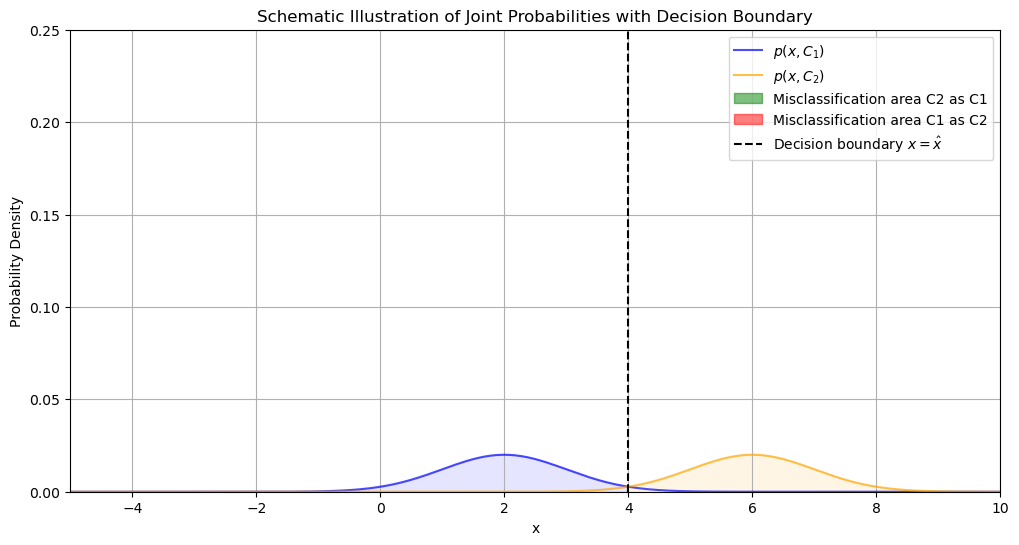

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a range of x values
x = np.linspace(-5, 10, 300)

# Parameters for the classes
mean_C1 = 2  # Mean for class C1
std_C1 = 1   # Standard deviation for class C1
mean_C2 = 6  # Mean for class C2
std_C2 = 1   # Standard deviation for class C2

# Joint probabilities p(x, C1) and p(x, C2)
p_C1 = (1/(std_C1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_C1) / std_C1) ** 2)
p_C2 = (1/(std_C2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_C2) / std_C2) ** 2)

# Normalize probabilities
p_C1 /= np.sum(p_C1)
p_C2 /= np.sum(p_C2)

# Decision boundary (x_b) - where p(C1) and p(C2) cross
x_b = (mean_C1 + mean_C2) / 2

# Plotting
plt.figure(figsize=(12, 6))

# Plot joint probabilities
plt.plot(x, p_C1, label=r'$p(x, C_1)$', color='blue', alpha=0.7)
plt.plot(x, p_C2, label=r'$p(x, C_2)$', color='orange', alpha=0.7)

# Fill areas for decision regions and misclassification
plt.fill_between(x, 0, p_C1, where=(x < x_b), color='blue', alpha=0.1)
plt.fill_between(x, 0, p_C2, where=(x >= x_b), color='orange', alpha=0.1)

# Misclassification areas
plt.fill_between(x, 0, p_C1, where=((x < x_b) & (p_C1 < p_C2)), color='green', alpha=0.5, label='Misclassification area C2 as C1')
plt.fill_between(x, 0, p_C2, where=((x >= x_b) & (p_C1 > p_C2)), color='red', alpha=0.5, label='Misclassification area C1 as C2')

# Draw the decision boundary
plt.axvline(x=x_b, color='black', linestyle='--', label=r'Decision boundary $x = \hat{x}$')

# Labels and legend
plt.title('Schematic Illustration of Joint Probabilities with Decision Boundary')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid()
plt.xlim(-5, 10)
plt.ylim(0, 0.25)

plt.show()


|             | Disease | Normal |
|-------------|---------|--------|
| Disease     | 0       | 1000   |
| Normal      | 1       | 0      |


Figure.25 An example of a loss matrix with elements $L_kj$ for the disease treatment problem. The rows correspond to the true class, whereas the columns cor- respond to the assignment of class made by our decision criterion.

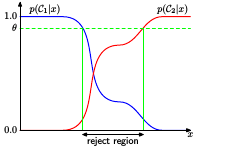

Figure.26 Illustration of the reject option. Inputs x such that the larger of the two poste- rior probabilities is less than or equal to some threshold θ will be rejected.


## 1.5.2 Minimizing the Expected Loss

For many applications, our objective will be more complex than simply minimizing the number of misclassifications. Let us consider again the medical diagnosis problem. We note that, if a patient who does not have a disease is incorrectly diagnosed as having a disease, the consequences may be some patient distress plus the need for further investigations. Conversely, if a patient with a disease is diagnosed as healthy, the result may be premature death due to lack of treatment. Thus, the consequences of these two types of mistakes can be dramatically different. It would clearly be better to make fewer mistakes of the second kind, even if this was at the expense of making more mistakes of the first kind.

We can formalize such issues through the introduction of a loss function, also called a cost function, which is a single, overall measure of loss incurred in taking any of the available decisions or actions. Our goal is then to minimize the total loss incurred. Note that some authors consider instead a utility function, whose value they aim to maximize. These are equivalent concepts if we take the utility to be simply the negative of the loss, and throughout this text we shall use the loss function convention.

Suppose that, for a new value of \( x \), the true class is \( C_k \) and that we assign \( x \) to class \( C_j \) (where \( j \) may or may not be equal to \( k \)). In so doing, we incur some level of loss that we denote by \( L_{kj} \), which we can view as the \( k, j \) element of a loss matrix. For instance, in our disease example, we might have a loss matrix of the form shown in Figure 1.25. This particular loss matrix says that there is no loss incurred if the correct decision is made, there is a loss of 1 if a healthy patient is diagnosed as having a disease, whereas there is a loss of 1000 if a patient having a disease is diagnosed as healthy.

The optimal solution is the one that minimizes the loss function. However, the loss function depends on the true class, which is unknown. For a given input vector \( x \), our uncertainty in the true class is expressed through the joint probability distribution \( p(x, C_k) \), and so we seek instead to minimize the average loss, where the average is computed with respect to this distribution, which is given by

$$
E[L] = \int \sum_{k,j} L_{kj} p(x, C_k) \, dx.
$$

Each \( x \) can be assigned independently to one of the decision regions \( R_j \). Our goal is to choose the regions \( R_j \) in order to minimize the expected loss, which implies that for each \( x \) we should minimize 

$$
\sum_k L_{kj} p(x, C_k).
$$

As before, we can use the product rule $ p(x, C_k) = p(C_k | x)p(x) $ to eliminate the common factor of $ p(x) $. Thus, the decision rule that minimizes the expected loss is the one that assigns each $ x $ to the class with the lowest expected loss.

## 1.5.3 The Reject Option

We have seen that classification errors arise from the regions of input space where the largest of the posterior probabilities $ p(C_k | x) $ is significantly less than unity, or equivalently where the joint distributions $ p(x, C_k) $ have comparable values. These are the regions where we are relatively uncertain about class membership. 

In some applications, it will be appropriate to avoid making decisions on the difficult cases in anticipation of a lower error rate on those examples for which a classification decision is made. This is known as the **reject option**. For example, in our hypothetical medical illustration, it may be appropriate to use an automatic system to classify those X-ray images for which there is little doubt as to the correct class, while leaving a human expert to classify the more ambiguous cases. 

We can achieve this by introducing a threshold $ \theta $ and rejecting those inputs $ x $ for which the largest of the posterior probabilities $ p(C_k | x) $ is less than or equal to $ \theta $. This is illustrated for the case of two classes, and a single continuous input variable $ x $, in Figure.26. 

Note that setting $ \theta = 1 $ will ensure that all examples are rejected, whereas if there are $ K $ classes, then setting $ \theta < \frac{1}{K} $ will ensure that no examples are rejected. Thus, the fraction of examples that get rejected is controlled by the value of $ \theta $. We can easily extend the reject criterion to minimize the expected loss when a loss matrix is given, taking account of the loss incurred when a reject decision is made.

## 1.5.4 Inference and Decision

We have broken the classification problem down into two separate stages: the inference stage in which we use training data to learn a model for $ p(C_k | x) $, and the subsequent decision stage in which we use these posterior probabilities to make optimal class assignments. 

An alternative possibility would be to solve both problems together and simply learn a function that maps inputs $ x $ directly into decisions. Such a function is called a **discriminant function**. In fact, we can identify three distinct approaches to solving decision problems, all of which have been used in practical applications. These are given, in decreasing order of complexity, by:

1. **Approach (a)**: First solve the inference problem of determining the class-conditional densities $ p(x|C_k) $ for each class $ C_k $ individually. Also separately infer the prior class probabilities $ p(C_k) $. Then use Bayes’ theorem in the form

   $$
   p(C_k | x) = \frac{p(x | C_k) p(C_k)}{p(x)} \, ,
   $$

   where the denominator \( p(x) \) can be found in terms of the quantities appearing in the numerator:

   $$
   p(x) = \sum_k p(x | C_k) p(C_k) \, .
   $$

   Equivalently, we can model the joint distribution $ p(x, C_k) $ directly and then normalize to obtain the posterior probabilities. Having found the posterior probabilities, we use decision theory to determine class membership for each new input $ x $. Approaches that explicitly or implicitly model the distribution of inputs as well as outputs are known as **generative models**, because by sampling from them, it is possible to generate synthetic data points in the input space.

2. **Approach (b)**: First solve the inference problem of determining the posterior class probabilities $ p(C_k | x) $, and then subsequently use decision theory to assign each new $ x $ to one of the classes. Approaches that model the posterior probabilities directly are called **discriminative models**.

3. **Approach (c)**: Find a function $ f(x) $, called a discriminant function, which maps each input $ x $ directly onto a class label. For instance, in the case of two-class problems, $ f(\cdot) $ might be binary valued such that $ f = 0 $ represents class $ C_1 $ and $ f = 1 $ represents class $ C_2 $. In this case, probabilities play no role.

Let us consider the relative merits of these three alternatives. Approach (a) is the most demanding because it involves finding the joint distribution over both $ x $ and $ C_k $. For many applications, $ x $ will have high dimensionality, and consequently, we may need a large training set in order to determine the class-conditional densities to reasonable accuracy. 

Note that the class priors $ p(C_k) $ can often be estimated simply from the fractions of the training set data points in each of the classes. One advantage of approach (a), however, is that it also allows the marginal density of data \( p(x) \) to be determined from the equation above. This can be useful for detecting new data points that have low probability under the model and for which the predictions may be uncertain.



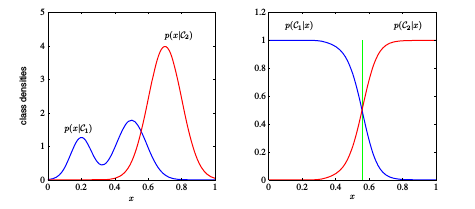

Figure.27 Example of the class-conditional densities for two classes having a single input variable x (left plot) together with the corresponding posterior probabilities (right plot). Note that the left-hand mode of the class-conditional density p(x|C1 ), shown in blue on the left plot, has no effect on the posterior probabilities. The vertical green line in the right plot shows the decision boundary in x that gives the minimum misclassiﬁcation rate.


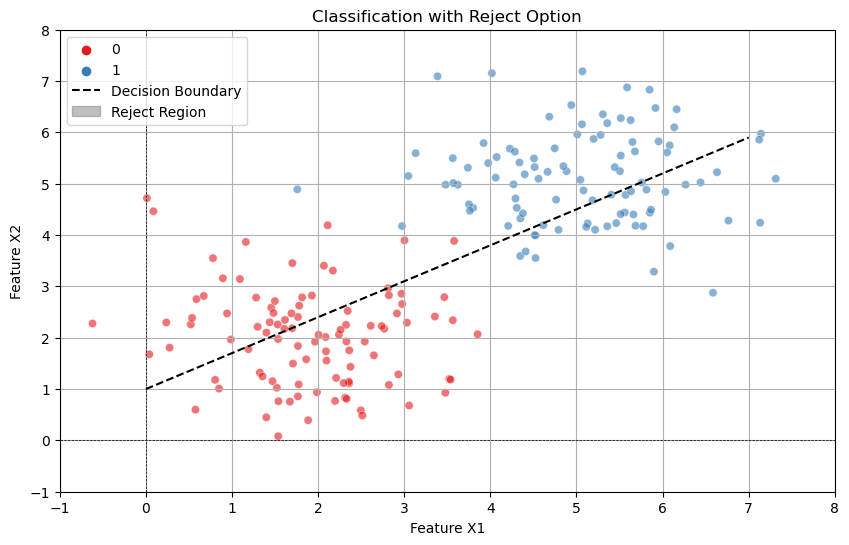

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic data
np.random.seed(42)
n_samples = 100

# Class C1
x1 = np.random.normal(loc=2, scale=1, size=n_samples)
y1 = np.random.normal(loc=2, scale=1, size=n_samples)

# Class C2
x2 = np.random.normal(loc=5, scale=1, size=n_samples)
y2 = np.random.normal(loc=5, scale=1, size=n_samples)

# Combine the data into a single DataFrame
data = np.concatenate([np.column_stack((x1, y1)), np.column_stack((x2, y2))])
labels = np.array([0] * n_samples + [1] * n_samples)  # 0 for C1, 1 for C2

# Plotting the classes
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels, palette='Set1', alpha=0.6)

# Decision boundary
decision_boundary_x = np.linspace(0, 7, 100)
decision_boundary_y = decision_boundary_x * 0.7 + 1  # Example linear decision boundary
plt.plot(decision_boundary_x, decision_boundary_y, color='black', linestyle='--', label='Decision Boundary')

# Reject Option
theta = 0.5  # Threshold for rejection
plt.fill_betweenx(np.linspace(-1, 8, 100), decision_boundary_x, decision_boundary_x + 1, where=decision_boundary_y <= theta, color='gray', alpha=0.5, label='Reject Region')

# Labels and title
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')
plt.title('Classification with Reject Option')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlim(-1, 8)
plt.ylim(-1, 8)
plt.legend()
plt.grid(True)
plt.show()


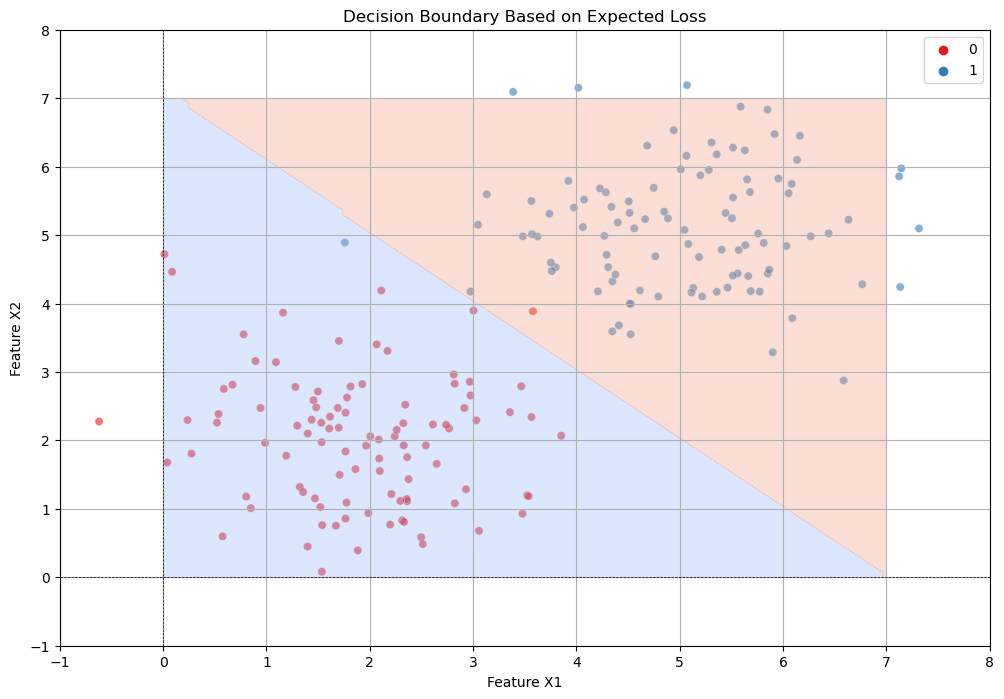

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic data
np.random.seed(42)
n_samples = 100

# Class C1
x1 = np.random.normal(loc=2, scale=1, size=n_samples)
y1 = np.random.normal(loc=2, scale=1, size=n_samples)

# Class C2
x2 = np.random.normal(loc=5, scale=1, size=n_samples)
y2 = np.random.normal(loc=5, scale=1, size=n_samples)

# Combine the data into a single DataFrame
data = np.concatenate([np.column_stack((x1, y1)), np.column_stack((x2, y2))])
labels = np.array([0] * n_samples + [1] * n_samples)  # 0 for C1, 1 for C2

# Loss matrix
loss_matrix = np.array([[0, 1],  # Loss for true class C1, predicted C1; C1, C2
                        [1000, 0]])  # Loss for true class C2, predicted C1; C2, C1

# Define the ranges for calculations
x_range = np.linspace(0, 7, 100)
y_range = np.linspace(0, 7, 100)
X, Y = np.meshgrid(x_range, y_range)

# Calculate the expected loss for each point in the space
expected_loss_C1 = np.zeros(X.shape)
expected_loss_C2 = np.zeros(X.shape)

# For simplicity, we will assume equal class prior probabilities
p_C1 = n_samples / (2 * n_samples)  # P(C1)
p_C2 = n_samples / (2 * n_samples)  # P(C2)

# Calculate expected loss for each point
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        # We will use a simple distance-based classification for this example
        dist_C1 = np.sqrt((X[i, j] - x1) ** 2 + (Y[i, j] - y1) ** 2).mean()
        dist_C2 = np.sqrt((X[i, j] - x2) ** 2 + (Y[i, j] - y2) ** 2).mean()
        
        # Assign to the class with minimum distance
        if dist_C1 < dist_C2:
            expected_loss_C1[i, j] = p_C1 * loss_matrix[0, 0] + p_C2 * loss_matrix[1, 0]
            expected_loss_C2[i, j] = p_C1 * loss_matrix[0, 1] + p_C2 * loss_matrix[1, 1]
        else:
            expected_loss_C1[i, j] = p_C1 * loss_matrix[0, 0] + p_C2 * loss_matrix[1, 1]
            expected_loss_C2[i, j] = p_C1 * loss_matrix[0, 1] + p_C2 * loss_matrix[1, 0]

# Decision boundary based on expected loss
decision_boundary = expected_loss_C1 < expected_loss_C2

# Plotting the data points, decision boundary, and expected loss
plt.figure(figsize=(12, 8))

# Plot the data points
sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels, palette='Set1', alpha=0.6)

# Plot the decision boundary
plt.contourf(X, Y, decision_boundary, alpha=0.3, cmap='coolwarm', levels=[-0.5, 0.5, 1.5])

# Labels and title
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')
plt.title('Decision Boundary Based on Expected Loss')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlim(-1, 8)
plt.ylim(-1, 8)
plt.grid(True)
plt.show()


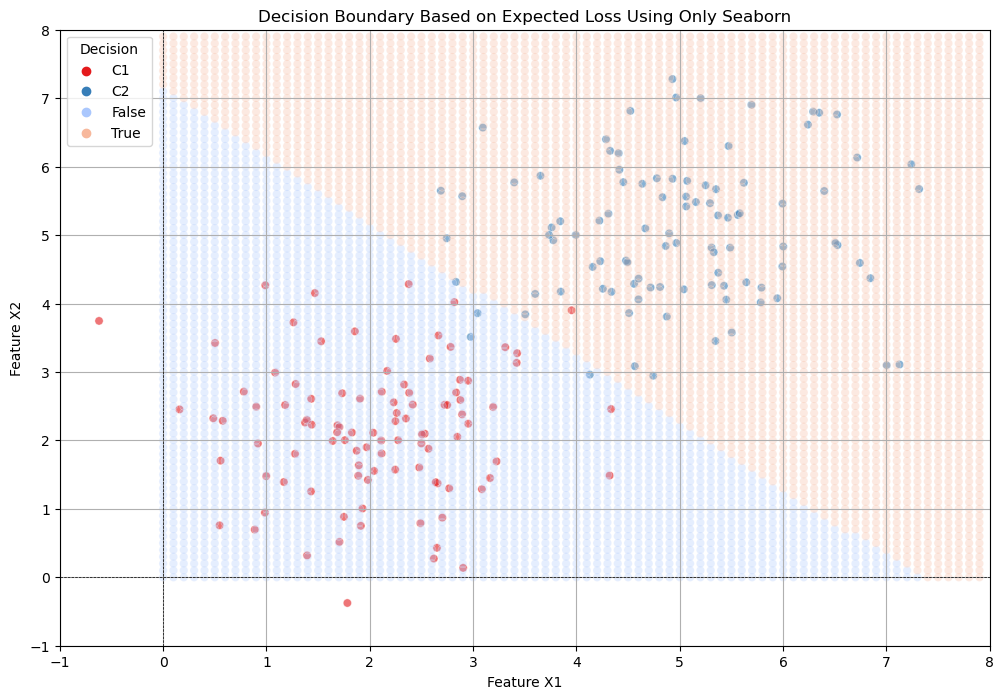

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random

# Generate synthetic data
random.seed(42)
n_samples = 100

# Class C1
x1 = [random.gauss(2, 1) for _ in range(n_samples)]
y1 = [random.gauss(2, 1) for _ in range(n_samples)]

# Class C2
x2 = [random.gauss(5, 1) for _ in range(n_samples)]
y2 = [random.gauss(5, 1) for _ in range(n_samples)]

# Combine the data into a single DataFrame
data = pd.DataFrame({
    'X1': x1 + x2,
    'X2': y1 + y2,
    'Class': ['C1'] * n_samples + ['C2'] * n_samples
})

# Loss matrix
loss_matrix = [[0, 1],  # C1 predicted as C1, C1 predicted as C2
               [1000, 0]]  # C2 predicted as C1, C2 predicted as C2

# Create a grid for decision boundary
x_range = [i / 10 for i in range(0, 80)]  # 0 to 8
y_range = [i / 10 for i in range(0, 80)]  # 0 to 8

# Initialize expected losses
expected_loss_C1 = []
expected_loss_C2 = []

# Calculate expected losses based on distances
for x in x_range:
    row_C1 = []
    row_C2 = []
    for y in y_range:
        # Calculate average distance to each class
        dist_C1 = sum(((x - x1_i) ** 2 + (y - y1_i) ** 2) ** 0.5 for x1_i, y1_i in zip(x1, y1)) / n_samples
        dist_C2 = sum(((x - x2_i) ** 2 + (y - y2_i) ** 2) ** 0.5 for x2_i, y2_i in zip(x2, y2)) / n_samples

        # Use distances to assign expected losses
        if dist_C1 < dist_C2:
            expected_loss_C1.append(loss_matrix[0][0] + loss_matrix[1][0])  # Predicted C1
            expected_loss_C2.append(loss_matrix[0][1] + loss_matrix[1][1])  # Predicted C2
        else:
            expected_loss_C1.append(loss_matrix[0][0] + loss_matrix[1][1])  # Predicted C1
            expected_loss_C2.append(loss_matrix[0][1] + loss_matrix[1][0])  # Predicted C2

# Create a DataFrame for expected losses
expected_losses = pd.DataFrame({
    'X1': x_range * len(y_range),
    'X2': sum([[y] * len(x_range) for y in y_range], []),
    'Expected_Loss_C1': expected_loss_C1,
    'Expected_Loss_C2': expected_loss_C2
})

# Determine decision boundary (where expected losses are equal)
expected_losses['Decision'] = expected_losses['Expected_Loss_C1'] < expected_losses['Expected_Loss_C2']

# Plotting
plt.figure(figsize=(12, 8))

# Plot the data points
sns.scatterplot(data=data, x='X1', y='X2', hue='Class', palette='Set1', alpha=0.6)

# Plot the decision boundary
sns.scatterplot(data=expected_losses, x='X1', y='X2', hue='Decision', palette='coolwarm', alpha=0.3, marker='o')

# Labels and title
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')
plt.title('Decision Boundary Based on Expected Loss Using Only Seaborn')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlim(-1, 8)
plt.ylim(-1, 8)
plt.grid(True)
plt.show()


# Application of Posterior Probabilities in Decision Making

If we know the posterior probabilities, we can trivially revise the minimum risk decision criterion by modifying the equation appropriately. If we have only a discriminant function, then any change to the loss matrix would require that we return to the training data and solve the classification problem afresh.

## Reject Option

Posterior probabilities allow us to determine a rejection criterion that will minimize the misclassification rate, or more generally the expected loss, for a given fraction of rejected data points.

## Compensating for Class Priors

Consider our medical X-ray problem again. Suppose we have collected a large number of X-ray images from the general population for use as training data in order to build an automated screening system. Because cancer is rare amongst the general population, we might find that, say, only 1 in every 1,000 examples corresponds to the presence of cancer. 

If we used such a data set to train an adaptive model, we could run into severe difficulties due to the small proportion of the cancer class. For instance, a classifier that assigned every point to the normal class would already achieve 99.9% accuracy, making it difficult to avoid this trivial solution. 

Even a large data set will contain very few examples of X-ray images corresponding to cancer, so the learning algorithm will not be exposed to a broad range of examples of such images and hence is not likely to generalize well. A balanced data set, in which we have selected equal numbers of examples from each of the classes, would allow us to find a more accurate model. 

However, we then have to compensate for the effects of our modifications to the training data. Suppose we have used such a modified data set and found models for the posterior probabilities. From Bayes' theorem:

$$
p(C_k | x) = \frac{p(x | C_k) p(C_k)}{p(x)}
$$

we see that the posterior probabilities are proportional to the prior probabilities, which we can interpret as the fractions of points in each class. Therefore, we can simply take the posterior probabilities obtained from our artificially balanced data set and first divide by the class fractions in that data set, and then multiply by the class fractions in the population to which we wish to apply the model. Finally, we need to normalize to ensure that the new posterior probabilities sum to one. 

Note that this procedure cannot be applied if we have learned a discriminant function directly instead of determining posterior probabilities.

## Combining Models

For complex applications, we may wish to break the problem into a number of smaller subproblems, each of which can be tackled by a separate module. For example, in our hypothetical medical diagnosis problem, we may have information available from blood tests as well as X-ray images. 

Rather than combine all of this heterogeneous information into one huge input space, it may be more effective to build one system to interpret the X-ray images and a different one to interpret the blood data. As long as each of the two models gives posterior probabilities for the classes, we can combine the outputs systematically using the rules of probability.

One simple way to do this is to assume that, for each class separately, the distributions of inputs for the X-ray images, denoted by $x_I$, and the blood data, denoted by $x_B$, are independent, so that:

$$
p(x_I, x_B | C_k) = p(x_I | C_k) p(x_B | C_k).
$$

This is an example of the conditional independence property, because the independence holds when the distribution is conditioned on the class $C_k$. 

The posterior probability, given both the X-ray and blood data, is then given by:

$$
p(C_k | x_I, x_B) \propto p(x_I, x_B | C_k) p(C_k) \propto p(x_I | C_k) p(x_B | C_k) p(C_k).
$$

Thus we need the class prior probabilities $p(C_k)$, which we can easily estimate from the fractions of data points in each class, and then we need to normalize the resulting posterior probabilities so they sum to one. 

The particular conditional independence assumption is an example of the naive Bayes model. Note that the joint marginal distribution $p(x_I, x_B)$ will typically not factorize under this model. We shall see in later chapters how to construct models for combining data that do not require the conditional independence assumption.


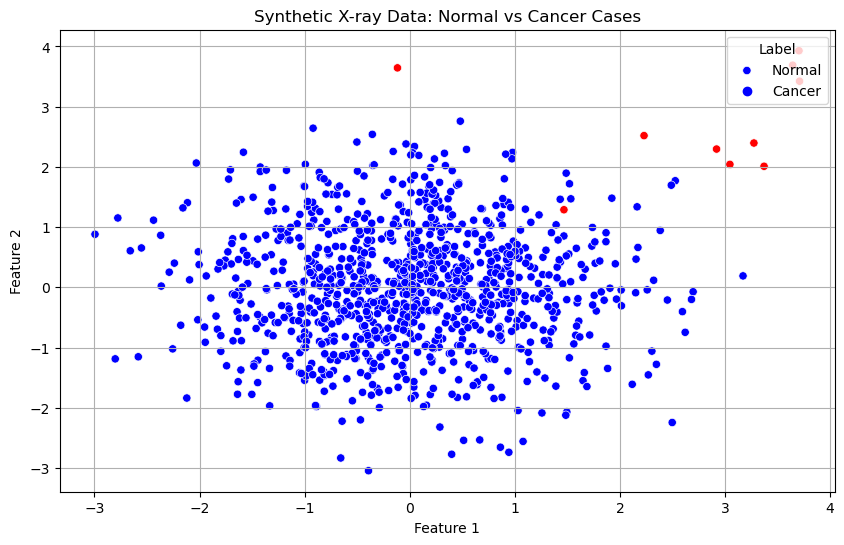

Prior Probability of Normal: 0.9901
Prior Probability of Cancer: 0.0099


ValueError: Data must be 1-dimensional

<Figure size 1000x600 with 0 Axes>

In [14]:
# Required libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(0)

# Generate synthetic data
# Assume we have 1000 normal cases and 10 cancer cases (imbalanced)
normal_cases = np.random.normal(loc=0, scale=1, size=(1000, 2))  # Normal class
cancer_cases = np.random.normal(loc=3, scale=1, size=(10, 2))   # Cancer class
data = np.vstack((normal_cases, cancer_cases))

# Create labels (0: Normal, 1: Cancer)
labels = np.array([0] * 1000 + [1] * 10)

# Ensure data is in the correct format
data = np.array(data)  # Convert to numpy array if it's not
labels = np.array(labels)

# Create a DataFrame for Seaborn
df = pd.DataFrame(data, columns=['Feature 1', 'Feature 2'])
df['Label'] = labels.reshape(-1)  # Reshape labels to be 1D

# Visualize the data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Feature 1', y='Feature 2', hue='Label', palette={0: 'blue', 1: 'red'})
plt.title('Synthetic X-ray Data: Normal vs Cancer Cases')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Label', loc='upper right', labels=['Normal', 'Cancer'])
plt.grid()
plt.show()

# Calculate prior probabilities
total_cases = len(labels)
prior_normal = np.sum(labels == 0) / total_cases
prior_cancer = np.sum(labels == 1) / total_cases

# Output prior probabilities
print(f"Prior Probability of Normal: {prior_normal:.4f}")
print(f"Prior Probability of Cancer: {prior_cancer:.4f}")

# Simulate posterior probability calculation using Naive Bayes assumption
def calculate_posterior(x, prior_normal, prior_cancer):
    # Assuming Gaussian distribution for features given classes
    mean_normal = np.mean(normal_cases, axis=0)
    mean_cancer = np.mean(cancer_cases, axis=0)
    
    var_normal = np.var(normal_cases, axis=0)
    var_cancer = np.var(cancer_cases, axis=0)
    
    # Calculate likelihoods (using Gaussian PDF)
    likelihood_normal = (1 / np.sqrt(2 * np.pi * var_normal)) * np.exp(-0.5 * ((x - mean_normal) ** 2) / var_normal)
    likelihood_cancer = (1 / np.sqrt(2 * np.pi * var_cancer)) * np.exp(-0.5 * ((x - mean_cancer) ** 2) / var_cancer)
    
    # Calculate posterior probabilities
    posterior_normal = likelihood_normal * prior_normal
    posterior_cancer = likelihood_cancer * prior_cancer
    
    # Normalize
    total = posterior_normal + posterior_cancer
    return posterior_normal / total, posterior_cancer / total

# Apply the posterior probability calculation to each point
posteriors = np.array([calculate_posterior(x, prior_normal, prior_cancer) for x in data])
posterior_normal, posterior_cancer = posteriors[:, 0], posteriors[:, 1]

# Visualize the posterior probabilities
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Feature 1', y='Feature 2', hue=posterior_cancer, palette='viridis', legend=None)
plt.title('Posterior Probability of Cancer for Each Data Point')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Posterior Probability of Cancer')
plt.grid()
plt.show()

# Decision threshold for classification
threshold = 0.5
predictions = (posterior_cancer > threshold).astype(int)

# Calculate classification accuracy
accuracy = np.mean(predictions == labels)
print(f"Classification Accuracy: {accuracy:.4f}")

# Visualization of predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Feature 1', y='Feature 2', hue=predictions, palette={0: 'blue', 1: 'red'})
plt.title('Predicted Classifications')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Prediction', loc='upper right', labels=['Normal', 'Cancer'])
plt.grid()
plt.show()


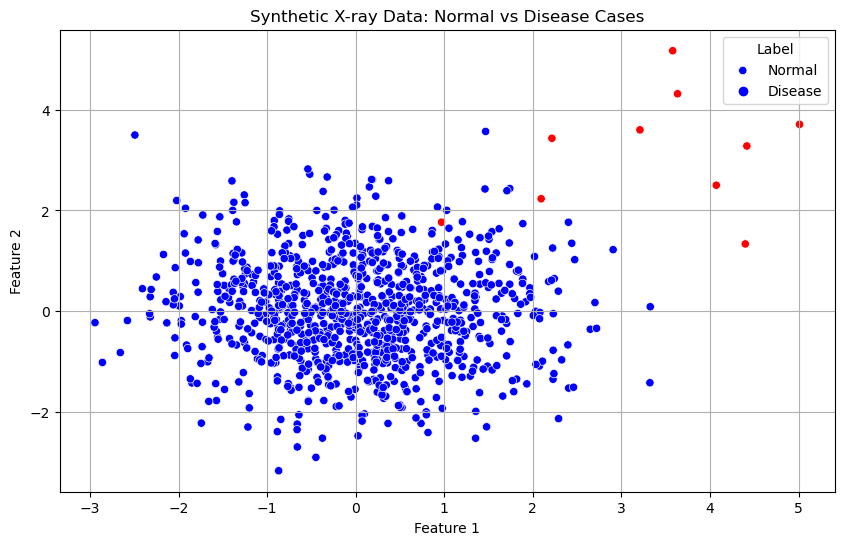

Prior Probability of Normal: 0.9901
Prior Probability of Disease: 0.0099


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

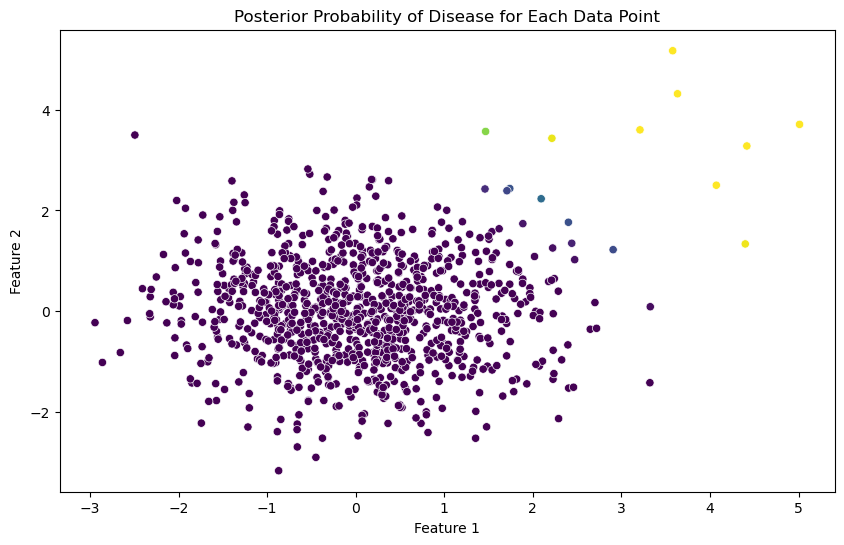

In [15]:
# Required libraries
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Set random seed for reproducibility
random.seed(0)

# Generate synthetic data
# Assume we have 1000 normal cases and 10 disease cases (imbalanced)
normal_cases = [(random.gauss(0, 1), random.gauss(0, 1)) for _ in range(1000)]  # Normal class
disease_cases = [(random.gauss(3, 1), random.gauss(3, 1)) for _ in range(10)]   # Disease class

# Combine data into a single list with labels
data = normal_cases + disease_cases
labels = [0] * 1000 + [1] * 10  # 0: Normal, 1: Disease

# Prepare the data for Seaborn
data_points = [(x[0], x[1], labels[i]) for i, x in enumerate(data)]

# Create a DataFrame-like structure using a list of tuples
def create_dataframe(data_points):
    """ Mimics DataFrame behavior for Seaborn plotting. """
    return {
        'Feature 1': [point[0] for point in data_points],
        'Feature 2': [point[1] for point in data_points],
        'Label': [point[2] for point in data_points]
    }

df = create_dataframe(data_points)

# Visualize the data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Feature 1'], y=df['Feature 2'], hue=df['Label'], palette={0: 'blue', 1: 'red'})
plt.title('Synthetic X-ray Data: Normal vs Disease Cases')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Label', loc='upper right', labels=['Normal', 'Disease'])
plt.grid()
plt.show()

# Calculate prior probabilities
total_cases = len(labels)
prior_normal = labels.count(0) / total_cases
prior_disease = labels.count(1) / total_cases

# Output prior probabilities
print(f"Prior Probability of Normal: {prior_normal:.4f}")
print(f"Prior Probability of Disease: {prior_disease:.4f}")

# Simulate posterior probability calculation using Naive Bayes assumption
def calculate_posterior(x, prior_normal, prior_disease):
    mean_normal = (0, 0)  # Mean for normal class (approximately)
    mean_disease = (3, 3)  # Mean for disease class (approximately)
    
    var_normal = (1, 1)  # Variance for normal class
    var_disease = (1, 1)  # Variance for disease class
    
    # Calculate likelihoods (using Gaussian PDF)
    likelihood_normal = (1 / ((2 * 3.14159 * var_normal[0]) ** 0.5)) * \
                        (1 / ((2 * 3.14159 * var_normal[1]) ** 0.5)) * \
                        (2.71828 ** (-0.5 * ((x[0] - mean_normal[0]) ** 2 / var_normal[0] +
                                             (x[1] - mean_normal[1]) ** 2 / var_normal[1])))
    
    likelihood_disease = (1 / ((2 * 3.14159 * var_disease[0]) ** 0.5)) * \
                         (1 / ((2 * 3.14159 * var_disease[1]) ** 0.5)) * \
                         (2.71828 ** (-0.5 * ((x[0] - mean_disease[0]) ** 2 / var_disease[0] +
                                              (x[1] - mean_disease[1]) ** 2 / var_disease[1])))

    # Calculate posterior probabilities
    posterior_normal = likelihood_normal * prior_normal
    posterior_disease = likelihood_disease * prior_disease
    
    # Normalize
    total = posterior_normal + posterior_disease
    return posterior_normal / total, posterior_disease / total

# Apply the posterior probability calculation to each point
posterior_results = [calculate_posterior(data[i], prior_normal, prior_disease) for i in range(len(data))]
posterior_disease = [result[1] for result in posterior_results]

# Visualize the posterior probabilities
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Feature 1'], y=df['Feature 2'], hue=posterior_disease, palette='viridis', legend=None)
plt.title('Posterior Probability of Disease for Each Data Point')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Posterior Probability of Disease')
plt.grid()
plt.show()

# Decision threshold for classification
threshold = 0.5
predictions = [1 if p > threshold else 0 for p in posterior_disease]

# Calculate classification accuracy
accuracy = sum([1 for i in range(len(predictions)) if predictions[i] == labels[i]]) / len(labels)
print(f"Classification Accuracy: {accuracy:.4f}")

# Visualization of predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Feature 1'], y=df['Feature 2'], hue=predictions, palette={0: 'blue', 1: 'red'})
plt.title('Predicted Classifications')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Prediction', loc='upper right', labels=['Normal', 'Disease'])
plt.grid()
plt.show()
